<a href="https://colab.research.google.com/github/Abhishek3009/CerebroSegNet/blob/main/model8_FeaturePyramidNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Feature Pyramid Network**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

!chmod 600 /content/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip \*.zip
!rm *.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')
import random
from glob import glob
from IPython.display import display

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Prepare dataset

In [ ]:
#Set Parameters
im_width = 256
im_height = 256

# **Load image's path and mask's path**

In [ ]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_13.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_11.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_10.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_19.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_7.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_12.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_25.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_29.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980

# **Data Visualization**

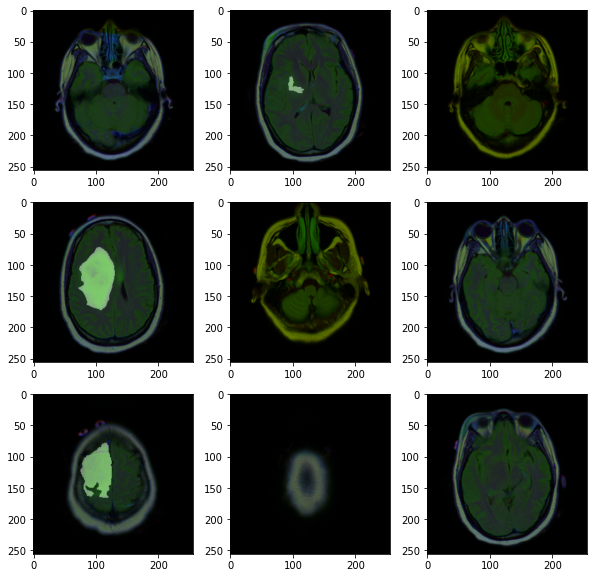

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

## **Create data frame and split data on train set, validation set and test set**

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


## **Data genertator, data augmentation and adjust data**

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

##**Model**

In [ ]:
def FPN_model(input_shape):

    input_layer = Input(input_shape)
    backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor = input_layer)
    c2_output, c3_output, c4_output, c5_output = [backbone.get_layer(layer_name).output for layer_name in ["conv2_block3_out", "conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
    print(c5_output.shape)
    print(c4_output.shape)
    print(c3_output.shape)
    print(c2_output.shape)
    print("#####################")

    r5_output = tf.keras.layers.Conv2D(256, 1, 1, "same")(c5_output)
    r4_output = tf.keras.layers.Conv2D(256, 1, 1, "same")(c4_output)
    r3_output = tf.keras.layers.Conv2D(256, 1, 1, "same")(c3_output)
    r2_output = tf.keras.layers.Conv2D(256, 1, 1, "same")(c2_output)
    print(r5_output.shape)
    print(r4_output.shape)
    print(r3_output.shape)
    print(r2_output.shape)
    print("#####################")

    a5_output = r5_output
    u5_output = tf.keras.layers.UpSampling2D(2)(a5_output)
    a4_output = tf.keras.layers.Add()([r4_output,u5_output])
    u4_output = tf.keras.layers.UpSampling2D(2)(a4_output)
    a3_output = tf.keras.layers.Add()([r3_output,u4_output])
    u3_output = tf.keras.layers.UpSampling2D(2)(a3_output)
    a2_output = tf.keras.layers.Add()([r2_output,u3_output])
    print(a5_output.shape)
    print(a4_output.shape)
    print(a3_output.shape)
    print(a2_output.shape)
    print("#####################")

    ar5 = tf.keras.layers.Conv2D(128,3,1,'same',kernel_initializer='he_normal')(a5_output)
    ar4 = tf.keras.layers.Conv2D(128,3,1,'same',kernel_initializer='he_normal')(a4_output)
    ar3 = tf.keras.layers.Conv2D(128,3,1,'same',kernel_initializer='he_normal')(a3_output)
    ar2 = tf.keras.layers.Conv2D(128,3,1,'same',kernel_initializer='he_normal')(a2_output)

    print(ar5.shape)
    print(ar4.shape)
    print(ar3.shape)
    print(ar2.shape)
    print("#####################")

    fb5 = tf.keras.layers.UpSampling2D(32)(ar5)
    fb4 = tf.keras.layers.UpSampling2D(16)(ar4)
    fb3 = tf.keras.layers.UpSampling2D(8)(ar3)
    fb2 = tf.keras.layers.UpSampling2D(4)(ar2)
    print(fb5.shape)
    print(fb4.shape)
    print(fb3.shape)
    print(fb2.shape)
    print("#####################")

    conc = tf.keras.layers.Concatenate()([fb5,fb4,fb3,fb2])
    final_conv = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1, 1),padding='same',kernel_initializer='he_normal', activation='sigmoid')(conc)
    print(final_conv.shape)

    model = tf.keras.Model(inputs=input_layer,outputs=final_conv)

    return model

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

fpn = FPN_model((img_height, img_width, num_channels))

(None, 8, 8, 2048)
(None, 16, 16, 1024)
(None, 32, 32, 512)
(None, 64, 64, 256)
#####################
(None, 8, 8, 256)
(None, 16, 16, 256)
(None, 32, 32, 256)
(None, 64, 64, 256)
#####################
(None, 8, 8, 256)
(None, 16, 16, 256)
(None, 32, 32, 256)
(None, 64, 64, 256)
#####################
(None, 8, 8, 128)
(None, 16, 16, 128)
(None, 32, 32, 128)
(None, 64, 64, 128)
#####################
(None, 256, 256, 128)
(None, 256, 256, 128)
(None, 256, 256, 128)
(None, 256, 256, 128)
#####################
(None, 256, 256, 1)


In [ ]:
fpn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow.keras import backend as K
EPOCHS = 50
BATCH_SIZE = 16
learning_rate = 0.001

In [ ]:
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon = 0.1)
fpn.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/fpn_seg_model.h5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
history = fpn.fit(train_gen,
                  epochs = EPOCHS,
                  steps_per_epoch=len(df_train) / BATCH_SIZE,
                  validation_data = val_gen,
                  validation_steps=len(df_val) / BATCH_SIZE,
                  callbacks = [checkpointer, earlystopping, reduce_lr])

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
177/176 [==============================] - ETA: 0s - loss: 0.6471 - tversky: 0.4267Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.99988, saving model to /content/fpn_seg_model.h5
176/176 [==============================] - 178s 916ms/step - loss: 0.6471 - tversky: 0.4267 - val_loss: 0.9999 - val_tversky: 1.6367e-04 - lr: 0.0010
Epoch 2/50
177/176 [==============================] - ETA: 0s - loss: 0.3648 - tversky: 0.7347
Epoch 2: val_loss improved from 0.99988 to 0.99988, saving model to /content/fpn_seg_model.h5
176/176 [==============================] - 155s 876ms/step - loss: 0.3648 - tversky: 0.7347 - val_loss: 0.9999 - val_tversky: 1.7675e-04 - lr: 0.0010
Epoch 3/50
177/176 [==============================] - ETA: 0s - loss: 0.3053 - tversky: 0.7911
Epoch 3: val_loss improved from 0.99988 to 0.99986, saving model to /content/fpn_

## Model Evaluation

In [ ]:
history.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

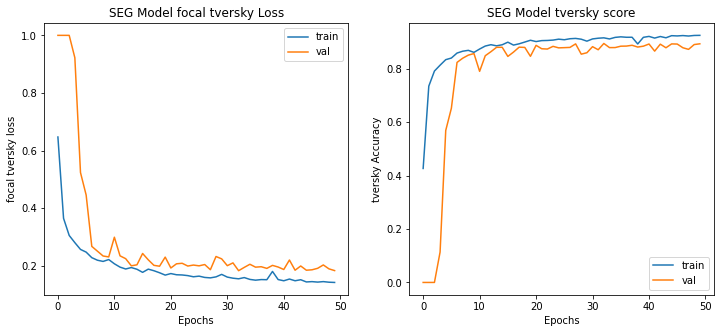

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

## Segmantation Model Performance

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = fpn.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 6s 231ms/step - loss: 0.1707 - tversky: 0.9045


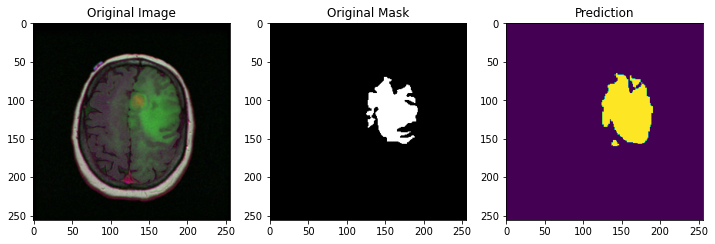

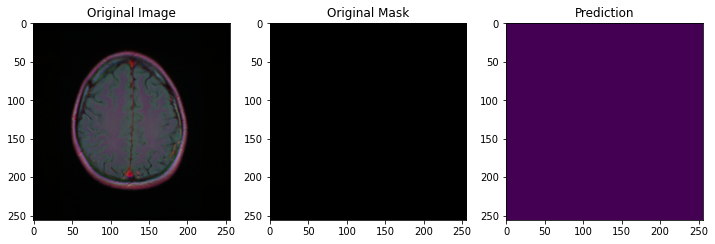

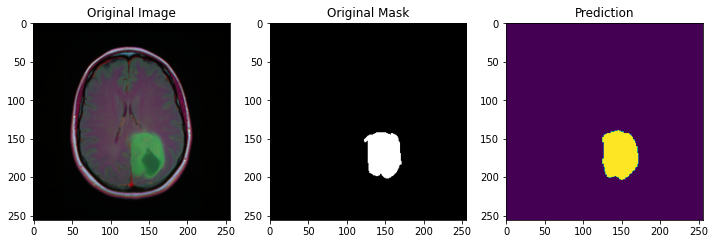

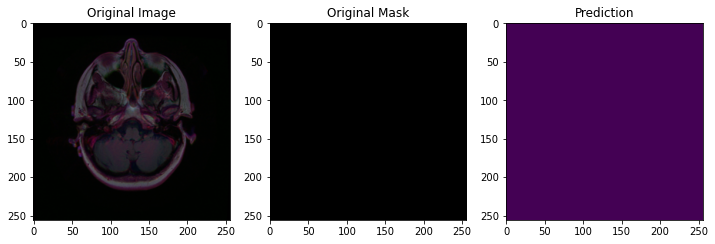

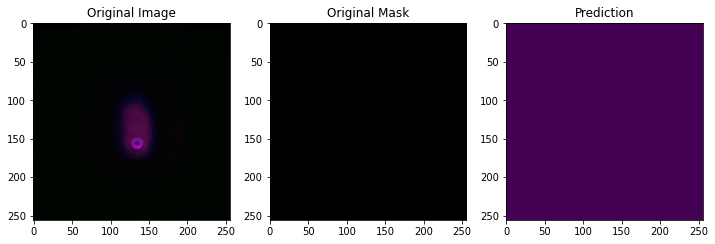

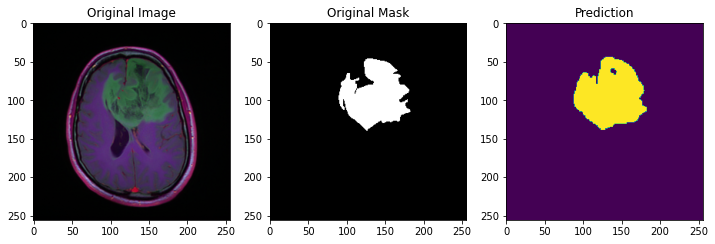

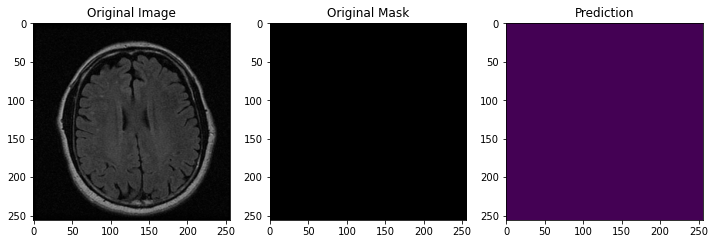

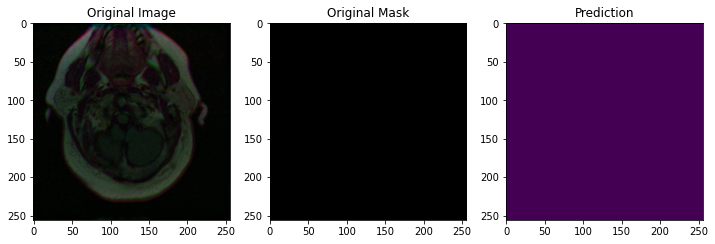

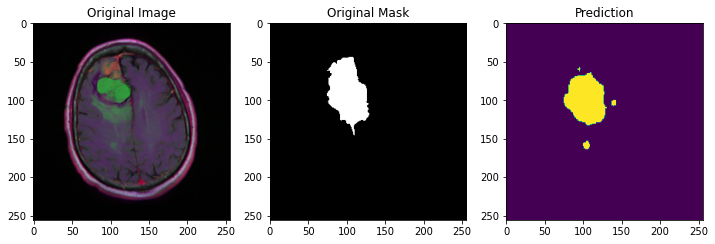

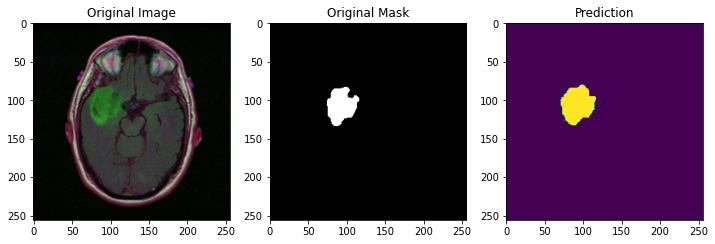

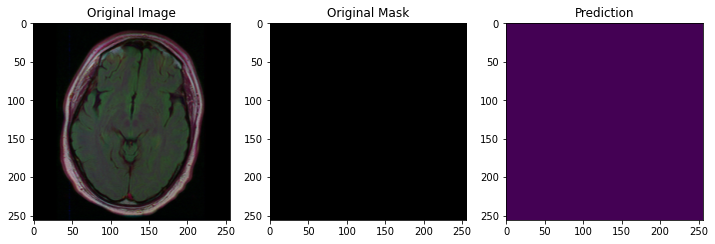

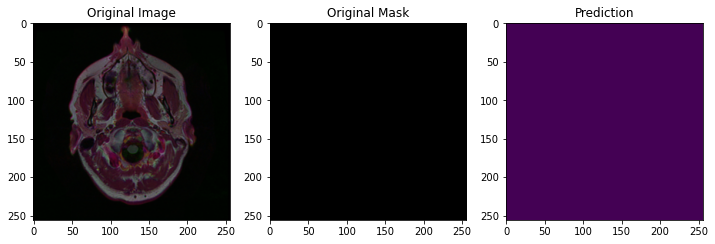

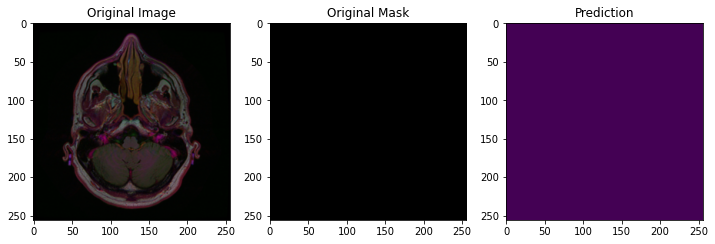

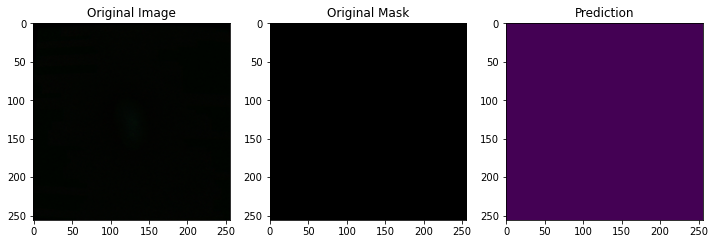

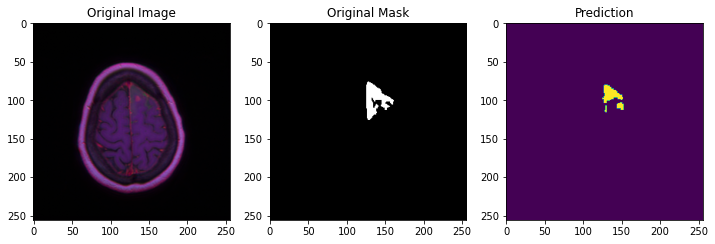

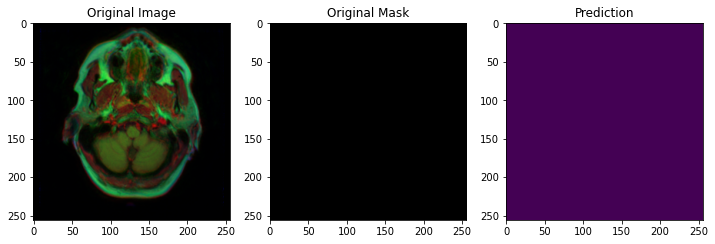

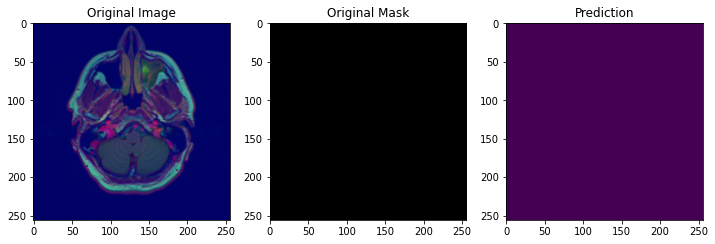

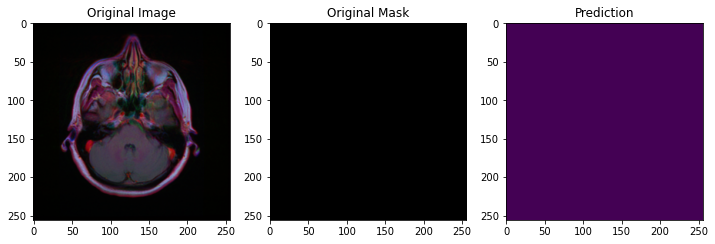

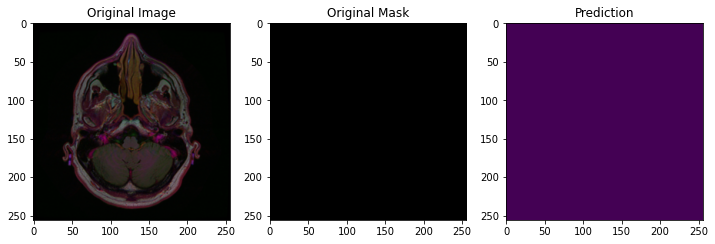

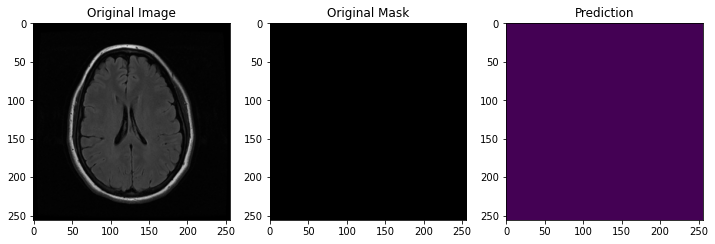

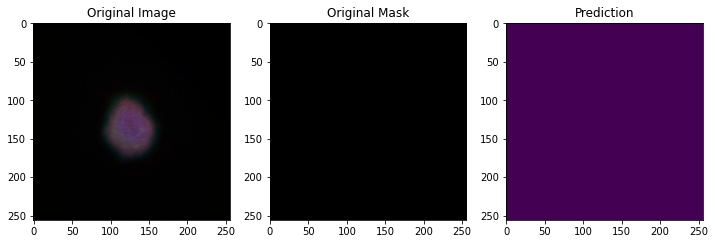

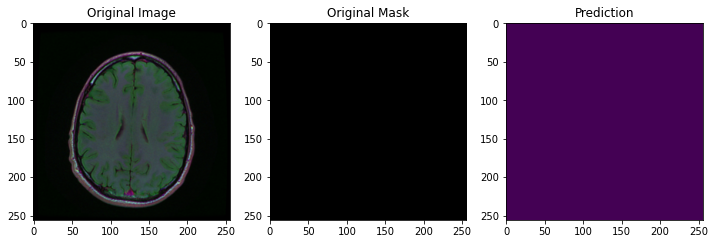

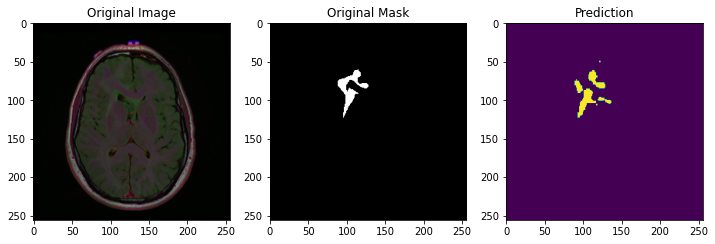

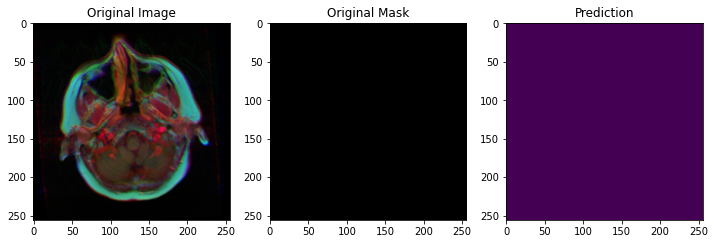

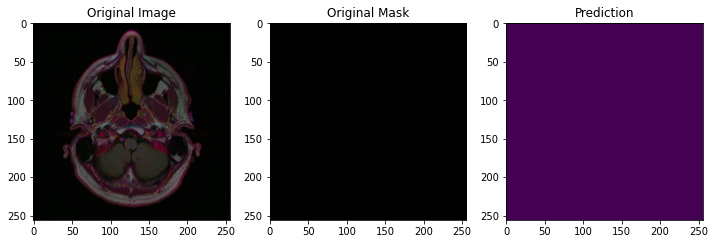

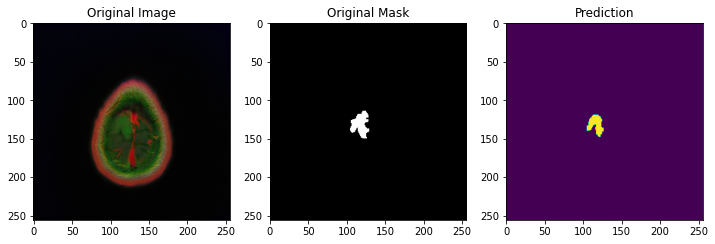

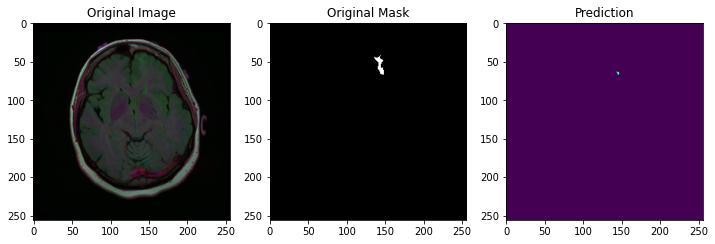

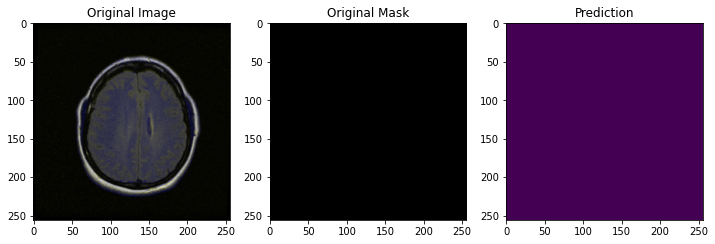

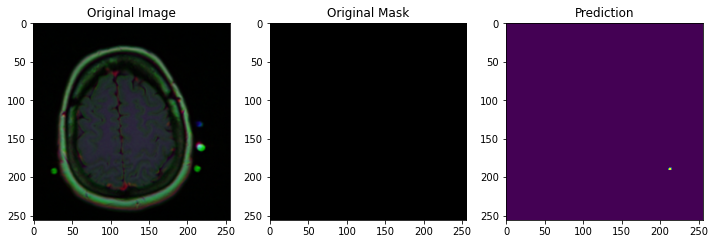

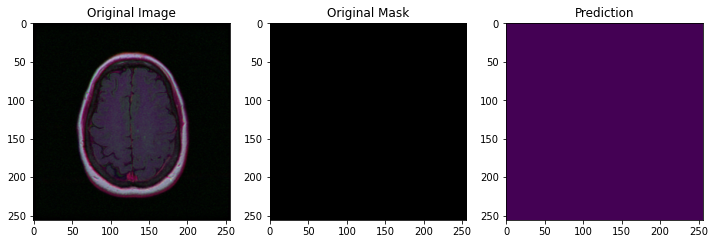

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred= fpn.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
